# 종합실습 2 - 압연공정 불량 예측 및 개선기회 도출

### 필요 패키지 호출

In [199]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import add_constant
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import graphviz
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix


- 폰트설정 및, 마이너스 기호 출력코드


In [187]:
matplotlib.rc('font', family = 'AppleGothic')
matplotlib.rc('axes', unicode_minus = False)

In [246]:
df_raw = pd.read_csv("SCALE불량.csv", encoding="euc-kr")
df_raw

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,PLT_1996,10JAN2023:05:32:25,양품,BV-A,프랑스,C,19,3400,41500,적용,...,1142,55,1151,86,203,1151,CR(제어압연),948,10,4조
996,PLT_1997,10JAN2023:05:39:19,양품,LR-A,영국,C,19,3400,41500,적용,...,1142,55,1151,86,209,1151,CR(제어압연),948,10,4조
997,PLT_1998,10JAN2023:05:52:41,양품,AB/AH32,미국,C,17,3400,43700,적용,...,1169,65,1163,77,227,1163,CR(제어압연),948,10,4조
998,PLT_1999,10JAN2023:06:01:50,양품,NV-A32,영국,C,17,3400,43700,적용,...,1169,65,1163,77,204,1163,CR(제어압연),948,10,4조


In [189]:
print(df_raw.shape)
df_raw.info()

(1000, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 n

- 데이터 확인 결과 총 1000개의 데이터 21개의 설명변수와 1개의 목표변수로 이루어져 있다.

## 1. 데이터 분석, 전처리
- 결측치 확인
- 필요없는 데이터 분리 및 목표변수/설명변수 분리
- 이상치 제거
- 변수 커스터마이징

### 결측치 확인


In [190]:
df_raw.isnull().sum()

plate_no           0
rolling_date       0
scale              0
spec_long          0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
fur_ex_temp        0
rolling_method     0
rolling_temp       0
descaling_count    0
work_group         0
dtype: int64

- 결측치가 없기 때문에 따로 제거할 필요가 없다.


### 열연작업시각 데이터, 철판번호 제거

- 인덱스 번호와 다름없는 철판번호는 필요하지 않기 때문에 제거한다.   
- 날짜 데이터도 관련이 없다고 판단하여 제거한다.   

In [191]:
df_raw.drop(["plate_no", "rolling_date"], axis=1, inplace=True)
df_raw.head()

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조
3,양품,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,1127,TMCP(온도제어),885,8,1조
4,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,1128,TMCP(온도제어),873,8,1조


### 변수 전처리

#### 현재 목표변수 scale이 양품, 불량품으로 나눠져 있으므로, 불량을 1 양품을 0으로 할당한다.

In [192]:
df_raw['scale'] = np.where(df_raw['scale'] == '양품', 0, 1)
df_raw['scale']

0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: scale, Length: 1000, dtype: int64

In [193]:
df_raw['scale'].value_counts()

0    690
1    310
Name: scale, dtype: int64

In [194]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scale            1000 non-null   int64 
 1   spec_long        1000 non-null   object
 2   spec_country     1000 non-null   object
 3   steel_kind       1000 non-null   object
 4   pt_thick         1000 non-null   int64 
 5   pt_width         1000 non-null   int64 
 6   pt_length        1000 non-null   int64 
 7   hsb              1000 non-null   object
 8   fur_no           1000 non-null   object
 9   fur_input_row    1000 non-null   object
 10  fur_heat_temp    1000 non-null   int64 
 11  fur_heat_time    1000 non-null   int64 
 12  fur_soak_temp    1000 non-null   int64 
 13  fur_soak_time    1000 non-null   int64 
 14  fur_total_time   1000 non-null   int64 
 15  fur_ex_temp      1000 non-null   int64 
 16  rolling_method   1000 non-null   object
 17  rolling_temp     1000 non-null   i

#### 데이터 형 변환 (Object) => (Category)

In [195]:
df_raw['spec_long'] = df_raw.spec_long.astype('category')
df_raw['spec_country'] = df_raw.spec_country.astype('category')
df_raw['steel_kind'] = df_raw.steel_kind.astype('category')
df_raw['hsb'] = df_raw.hsb.astype('category')
df_raw['fur_no'] = df_raw.fur_no.astype('category')
df_raw['fur_input_row'] = df_raw.fur_input_row.astype('category')
df_raw['rolling_method'] = df_raw.rolling_method.astype('category')
df_raw['work_group'] = df_raw.work_group.astype('category')

In [196]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   scale            1000 non-null   int64   
 1   spec_long        1000 non-null   category
 2   spec_country     1000 non-null   category
 3   steel_kind       1000 non-null   category
 4   pt_thick         1000 non-null   int64   
 5   pt_width         1000 non-null   int64   
 6   pt_length        1000 non-null   int64   
 7   hsb              1000 non-null   category
 8   fur_no           1000 non-null   category
 9   fur_input_row    1000 non-null   category
 10  fur_heat_temp    1000 non-null   int64   
 11  fur_heat_time    1000 non-null   int64   
 12  fur_soak_temp    1000 non-null   int64   
 13  fur_soak_time    1000 non-null   int64   
 14  fur_total_time   1000 non-null   int64   
 15  fur_ex_temp      1000 non-null   int64   
 16  rolling_method   1000 non-null   category
 

### 이상치 제거
- 하단 탐색적 분석 진행도중 ROLLING_TEMP_T5의 이상치 확인
- 0 데이터가 나오는 것으로 보임으로 해당 데이터 삭제를 함

<AxesSubplot: >

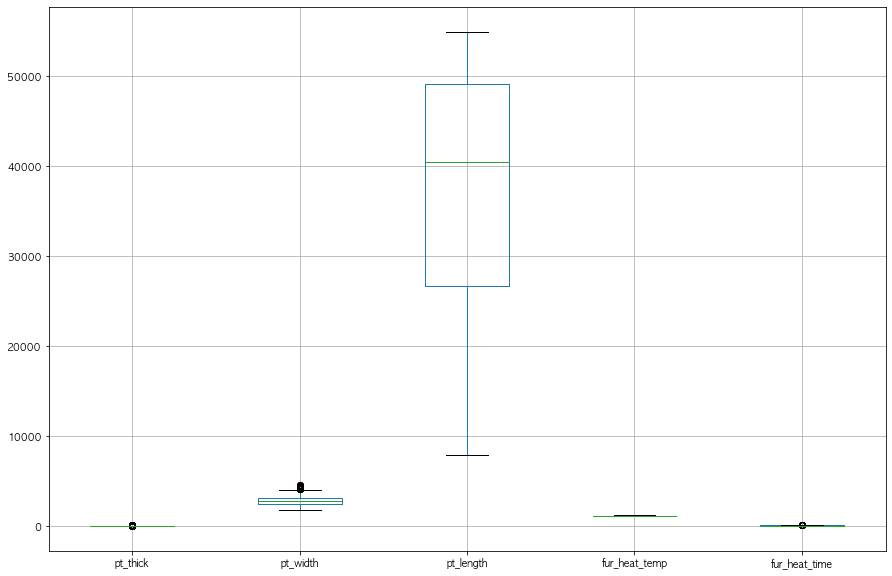

In [165]:
df_raw[["pt_thick", 'pt_width', 'pt_length', 'fur_heat_temp', 'fur_heat_time']].boxplot(figsize = (15, 10))

<AxesSubplot: >

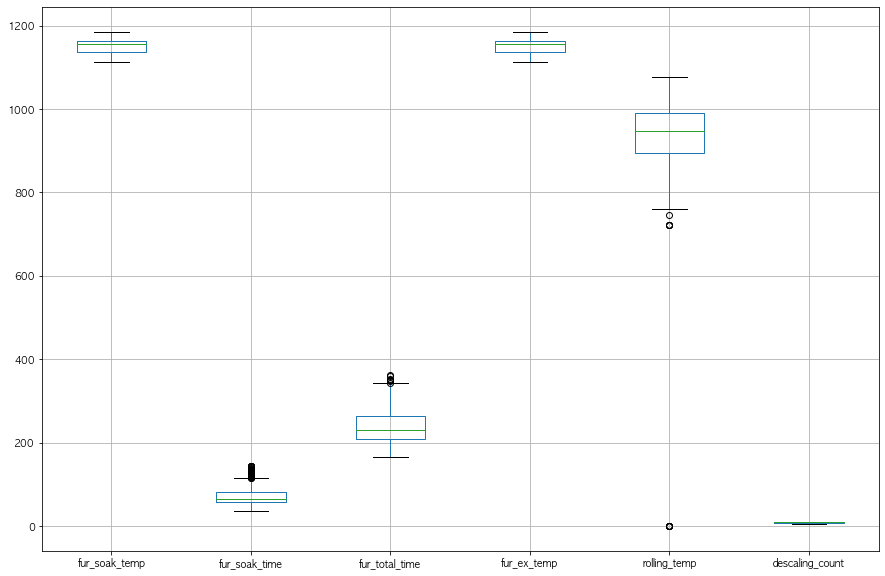

In [166]:
df_raw[["fur_soak_temp", 'fur_soak_time', 'fur_total_time', 'fur_ex_temp', 'rolling_temp', 'descaling_count']].boxplot(figsize = (15, 10))

- 그래프를 비교해 본 결과 rolling temp에 이상치가 있는 것으로 보이며, fur_soak_temp와 fur_ex_temp가 동일한 분포인 것으로 보인다.

In [167]:
df_raw['rolling_temp'].sort_values()

221       0
53        0
599       0
600       0
222       0
       ... 
188    1066
191    1068
715    1071
716    1071
187    1078
Name: rolling_temp, Length: 1000, dtype: int64

0도인 컬럼들이 존재하니 이를 확인한다.

In [168]:
df_raw[df_raw['rolling_temp'] == 0]

,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
53,0,GL-E36-TM,독일,T,56,3800,11400,적용,3호기,2열,1132,95,1128,80,244,1128,TMCP(온도제어),0,6,1조
221,0,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,2열,1163,57,1166,67,228,1166,CR(제어압연),0,10,2조
222,0,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,1열,1169,64,1164,61,188,1164,CR(제어압연),0,10,2조
598,0,PILAC-BT33,한국,T,81,2100,12900,적용,2호기,1열,1133,89,1122,59,229,1122,CR(제어압연),0,6,3조
599,0,PILAC-BT33,한국,T,81,2100,13200,적용,1호기,2열,1130,92,1124,61,210,1124,CR(제어압연),0,6,3조
600,0,NV-D32-TM,영국,T,40,2500,23600,적용,3호기,1열,1119,109,1117,76,260,1117,TMCP(온도제어),0,6,3조


가열로 온도가 0도 인 것은 이상치로 볼 수 있으므로 이를 삭제한다.
- 이상치 6개 삭제

In [169]:
df_raw = df_raw[df_raw['rolling_temp'] > 10]
df_raw.reset_index(inplace=True)
df_raw.shape

(994, 21)

In [170]:
(df_raw['fur_soak_temp'] == df_raw['fur_ex_temp']).value_counts()

True    994
dtype: int64

- 둘 중 fur_soak_temp 칼럼을 삭제한다.

In [171]:
df_raw = df_raw.drop(labels='fur_soak_temp', axis= 1)
df_raw

,index,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,0,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,1열,1144,116,59,259,1133,TMCP(온도제어),934,8,1조
1,1,0,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,2열,1144,122,53,238,1135,TMCP(온도제어),937,8,1조
2,2,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,1열,1129,116,55,258,1121,TMCP(온도제어),889,8,1조
3,3,0,NV-E36-TM,영국,T,33,3600,19200,적용,2호기,2열,1152,125,68,266,1127,TMCP(온도제어),885,8,1조
4,4,0,BV-EH36-TM,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,48,246,1128,TMCP(온도제어),873,8,1조
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,995,0,BV-A,프랑스,C,19,3400,41500,적용,1호기,2열,1142,55,86,203,1151,CR(제어압연),948,10,4조
990,996,0,LR-A,영국,C,19,3400,41500,적용,1호기,2열,1142,55,86,209,1151,CR(제어압연),948,10,4조
991,997,0,AB/AH32,미국,C,17,3400,43700,적용,2호기,2열,1169,65,77,227,1163,CR(제어압연),948,10,4조
992,998,0,NV-A32,영국,C,17,3400,43700,적용,2호기,2열,1169,65,77,204,1163,CR(제어압연),948,10,4조


### 히스토그램 - 양품/불량 기준(연속형 데이터)

In [172]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   index            994 non-null    int64   
 1   scale            994 non-null    int64   
 2   spec_long        994 non-null    category
 3   spec_country     994 non-null    category
 4   steel_kind       994 non-null    category
 5   pt_thick         994 non-null    int64   
 6   pt_width         994 non-null    int64   
 7   pt_length        994 non-null    int64   
 8   hsb              994 non-null    category
 9   fur_no           994 non-null    category
 10  fur_input_row    994 non-null    category
 11  fur_heat_temp    994 non-null    int64   
 12  fur_heat_time    994 non-null    int64   
 13  fur_soak_time    994 non-null    int64   
 14  fur_total_time   994 non-null    int64   
 15  fur_ex_temp      994 non-null    int64   
 16  rolling_method   994 non-null    category
 1

### 후판 두께

<AxesSubplot: xlabel='pt_thick', ylabel='Count'>

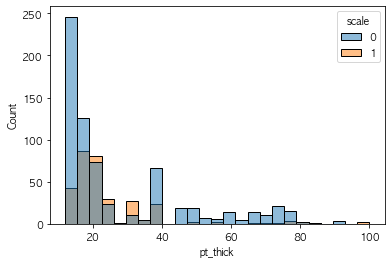

In [173]:
sns.histplot(data = df_raw, x = 'pt_thick', hue = 'scale')

### 후판 지시폭

<AxesSubplot: xlabel='pt_width', ylabel='Count'>

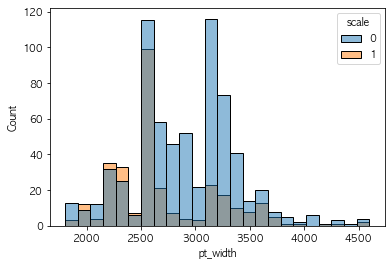

In [174]:
sns.histplot(data = df_raw, x = 'pt_width', hue = 'scale')

### 후판 지시길이

<AxesSubplot: xlabel='pt_length', ylabel='Count'>

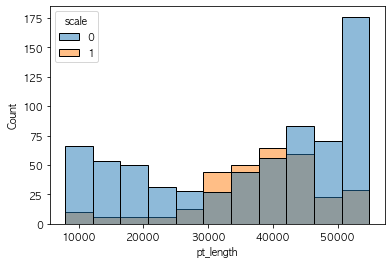

In [175]:
sns.histplot(data = df_raw, x = 'pt_length', hue = 'scale')

### 후판 가열대 소재온도

<AxesSubplot: xlabel='fur_heat_temp', ylabel='Count'>

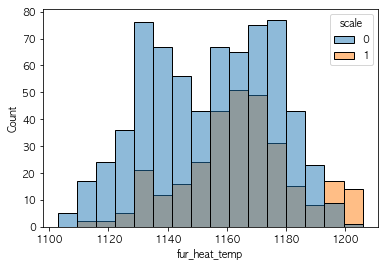

In [176]:
sns.histplot(data = df_raw, x = 'fur_heat_temp', hue = 'scale')

### 가열대 재로시간

<AxesSubplot: xlabel='fur_heat_time', ylabel='Count'>

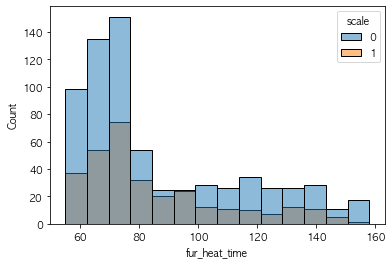

In [177]:
sns.histplot(data = df_raw, x = 'fur_heat_time', hue = 'scale')

### 균열대 소재온도

<AxesSubplot: xlabel='fur_soak_time', ylabel='Count'>

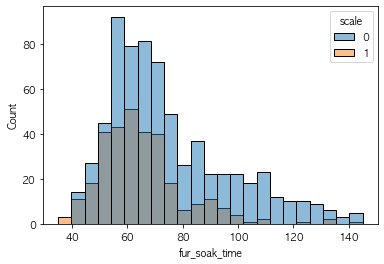

In [178]:
sns.histplot(data = df_raw, x = 'fur_soak_time', hue = 'scale')

### 총 재로시간

<AxesSubplot: xlabel='fur_total_time', ylabel='Count'>

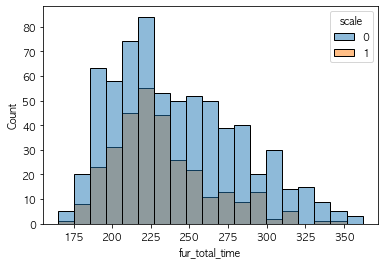

In [179]:
sns.histplot(data = df_raw, x = 'fur_total_time', hue = 'scale')

### 가열로 추출온도

<AxesSubplot: xlabel='fur_ex_temp', ylabel='Count'>

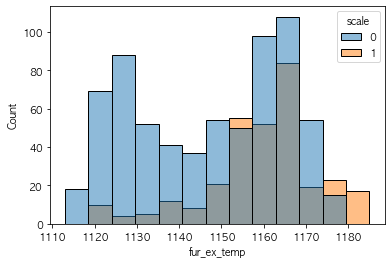

In [180]:
sns.histplot(data = df_raw, x = 'fur_ex_temp', hue = 'scale')

### 압연온도

<AxesSubplot: xlabel='rolling_temp', ylabel='Count'>

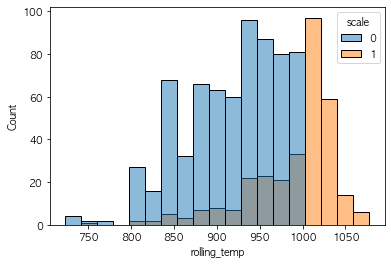

In [181]:
sns.histplot(data = df_raw, x = 'rolling_temp', hue = 'scale')

### 압연 횟수


<AxesSubplot: xlabel='descaling_count', ylabel='Count'>

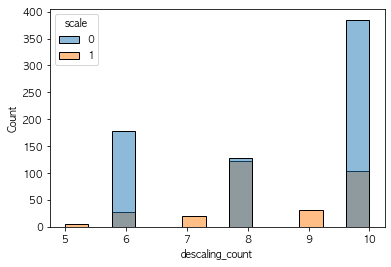

In [202]:
sns.histplot(data = df_raw, x = 'descaling_count', hue = 'scale')

- 압연 온도가 스케일 발생의 핵심적인 요인으로 보인다.


#### 작업조

In [207]:
pd.crosstab(df_raw["scale"], df_raw['work_group'], margins=True)


work_group,1조,2조,3조,4조,All
scale,,,,,
0,171,207,152,160,690
1,109,85,66,50,310
All,280,292,218,210,1000


- 조별로 양품과 불량률에 차이가 크게 없어 보이기에 이번 분석에서는 사용하지 않는다.

#### HSB(HSB적용 유무 1- 불량, 0 - 양품)

In [208]:
pd.crosstab(df_raw["scale"], df_raw['hsb'], margins=True)


hsb,미적용,적용,All
scale,,,
0,0,690,690
1,47,263,310
All,47,953,1000


- HSB미적용시 모두 불량임을 확인할 수 있다.
- hsb 적용 유무와 스케일 발생과는 유의미한 차이가 있어보인다.

#### 강종 별

In [209]:
pd.crosstab(df_raw["scale"], df_raw['steel_kind'], margins=True)


steel_kind,C,T,All
scale,,,
0,465,225,690
1,290,20,310
All,755,245,1000


- c종에서 많은 스케일이 발생한 것을 확인했다.
- 강종별로 스케일 발생의 유의미한 차이가 있을 것으로 보인다.

###

## 2. 모델링 기법

# 1. 로지스틱 회귀분석

### 데이터 분할

In [210]:
df_train, df_test = train_test_split(df_raw,
                                     test_size =0.3, random_state=1234)

print("train data size: {}".format(df_train.shape))
print("Test data size: {}".format(df_test.shape))

train data size: (700, 20)
Test data size: (300, 20)


In [211]:
log_model = Logit.from_formula("scale ~ steel_kind + pt_thick + pt_width + pt_length"
                               "+ fur_no + fur_input_row + fur_heat_temp + fur_heat_time + fur_soak_temp"
                               "+ fur_soak_time + fur_total_time + rolling_method + rolling_temp + descaling_count", df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.392153
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  700
Model:                          Logit   Df Residuals:                      684
Method:                           MLE   Df Model:                           15
Date:                Tue, 23 May 2023   Pseudo R-squ.:                  0.3654
Time:                        23:43:09   Log-Likelihood:                -274.51
converged:                       True   LL-Null:                       -432.57
Covariance Type:            nonrobust   LLR p-value:                 2.476e-58
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      -88.5905     17.373     -5.099      0.000

설명력이 36.5%정도로 매우 낮기 떄문에 회귀분석은 사용하지 않는다.

# 2. 의사결정나무

In [216]:
df_raw_y = df_raw["scale"]
df_raw_x = df_raw.drop("scale",axis = 1, inplace = False)
df_raw_x.shape, df_raw_y.shape

((1000, 19), (1000,))

### 더미변수 생성

In [213]:
df_raw_x_dummy = pd.get_dummies(df_raw_x)
df_raw_x_dummy.head()
df_raw_x_dummy.shape

(1000, 99)

### 데이터 분할

In [217]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x_dummy, df_raw_y, test_size=0.3, random_state=1234)

print("train dzta X size : {}".format(df_train_x.shape))
print("train dzta Y size : {}".format(df_train_y.shape))
print("test dzta X size : {}".format(df_test_x.shape))
print("test dzta Y size : {}".format(df_test_y.shape))

train dzta X size : (700, 99)
train dzta Y size : (700,)
test dzta X size : (300, 99)
test dzta Y size : (300,)


In [218]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.990


In [219]:
dt = DecisionTreeClassifier()

# 탐색할 매개변수 그리드 설정
param_grid = {
    "max_depth": range(2, 20),
    "min_samples_split": range(2, 40, 2),
    "min_samples_leaf": range(2, 20, 2)
}

# GridSearchCV를 사용하여 최적 매개변수 탐색
grid_search = GridSearchCV(dt, param_grid,scoring = "accuracy", n_jobs = -1)
grid_search.fit(df_train_x, df_train_y)

# 최적 매개변수 및 모델 출력
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_

accuracy = best_model.score(df_test_x, df_test_y)
print("Test Accuracy: ", accuracy)

Best Parameters:  {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 4}
Best Score:  0.9800000000000001
Test Accuracy:  0.99


In [220]:
tree_final = DecisionTreeClassifier(min_samples_leaf = 2,min_samples_split = 6,max_depth = 6, random_state=1234,)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=6,
                       random_state=1234)

In [240]:
dt_pred = tree_final.predict(df_test_x)

print("Accuray: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuray: 0.993

Confusion matrix:
[[206   0]
 [ 12  82]]


### 변수 중요도

In [222]:
v_feature_name = df_train_x.columns


df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = tree_final.feature_importances_

df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
9,rolling_temp,0.554
86,hsb_미적용,0.155
5,fur_soak_temp,0.146
10,descaling_count,0.145
0,pt_thick,0.000
...,...,...
32,spec_long_GL-A32,0.000
31,spec_long_GL-A,0.000
30,spec_long_COMMON,0.000
29,spec_long_CCS-B,0.000


# 3. 랜덤포레스트

In [224]:
rf_uncustomized = RandomForestClassifier(random_state = 1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.990


In [225]:
dt = RandomForestClassifier()

# 탐색할 매개변수 그리드 설정
param_grid = {
    "max_depth": range(2, 20),
    "min_samples_split": range(2, 40, 2),
    "min_samples_leaf": range(2, 20, 2)
}

# GridSearchCV를 사용하여 최적 매개변수 탐색
grid_search = GridSearchCV(dt, param_grid,scoring = "accuracy", n_jobs = -1)
grid_search.fit(df_train_x, df_train_y)

# 최적 매개변수 및 모델 출력
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_

accuracy = best_model.score(df_test_x, df_test_y)
print("Test Accuracy: ", accuracy)

Best Parameters:  {'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 14}
Best Score:  0.9514285714285714
Test Accuracy:  0.9633333333333334


In [226]:
rf_final = RandomForestClassifier(min_samples_leaf = 2,min_samples_split = 14,max_depth = 19, random_state=1234,)
rf_final.fit(df_train_x, df_train_y)

RandomForestClassifier(max_depth=19, min_samples_leaf=2, min_samples_split=14,
                       random_state=1234)

In [241]:
rf_pred = rf_final.predict(df_test_x)

print("Accuray: {0:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuray: 0.960

Confusion matrix:
[[206   0]
 [ 12  82]]


In [228]:
v_feature_name = df_train_x.columns


df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = tree_final.feature_importances_

df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
9,rolling_temp,0.554
86,hsb_미적용,0.155
5,fur_soak_temp,0.146
10,descaling_count,0.145
0,pt_thick,0.000
...,...,...
32,spec_long_GL-A32,0.000
31,spec_long_GL-A,0.000
30,spec_long_COMMON,0.000
29,spec_long_CCS-B,0.000


# 4. 그레디언트 부스팅

In [229]:
gb_uncustomized = GradientBoostingClassifier(random_state = 1234)
gb_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.997


In [231]:
dt = GradientBoostingClassifier()

# 탐색할 매개변수 그리드 설정
param_grid = {
    "max_depth": range(2, 20),
    "min_samples_split": range(2, 40, 2),
    "min_samples_leaf": range(2, 20, 2)
}

# GridSearchCV를 사용하여 최적 매개변수 탐색
grid_search = GridSearchCV(dt, param_grid,scoring = "accuracy", n_jobs = -1)
grid_search.fit(df_train_x, df_train_y)

# 최적 매개변수 및 모델 출력
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
best_model = grid_search.best_estimator_

accuracy = best_model.score(df_test_x, df_test_y)
print("Test Accuracy: ", accuracy)

Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Score:  0.9971428571428571
Test Accuracy:  0.9966666666666667


In [232]:
gb_final = GradientBoostingClassifier(min_samples_leaf = 2,min_samples_split = 10,max_depth = 5, random_state=1234,)
gb_final.fit(df_train_x, df_train_y)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=2,
                           min_samples_split=10, random_state=1234)

In [233]:
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.997


In [242]:
gb_pred = gb_final.predict(df_test_x)

print("Accuray: {0:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y, gb_pred)))

Accuray: 0.997

Confusion matrix:
[[206   0]
 [  1  93]]


In [235]:
v_feature_name = df_train_x.columns


df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["importance"] = tree_final.feature_importances_

df_importance.sort_values("importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,importance
9,rolling_temp,0.554
86,hsb_미적용,0.155
5,fur_soak_temp,0.146
10,descaling_count,0.145
0,pt_thick,0.000
...,...,...
32,spec_long_GL-A32,0.000
31,spec_long_GL-A,0.000
30,spec_long_COMMON,0.000
29,spec_long_CCS-B,0.000


## 5. 정확도 및 Confusion Matrix

In [243]:
# 의사결정나무
print("Accuracy:{0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test_y, dt_pred)))

Accuracy:0.993

Confusion Matrix: 
[[206   0]
 [  2  92]]


In [244]:
# 랜덤포레스트

print("Accuracy on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))
print("Comfusion Matrix: \n{}".format(confusion_matrix(df_test_y, rf_pred)))

Accuracy on test set: 0.960
Comfusion Matrix: 
[[206   0]
 [ 12  82]]


In [245]:
# 그레디언트 부스팅
print("Accuracy on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))
print("Comfusion Matrix: \n{}".format(confusion_matrix(df_test_y, gb_pred)))

Accuracy on test set: 0.997
Comfusion Matrix: 
[[206   0]
 [  1  93]]


- Confusion Matrix나 정확도 면에서 그레디언트 부스팅이 우수하므로 이 모델을 사용하는 것이 적합하다.